# Chatbot with Profile Schema


Our chatbot saved memories as a string. In practice, we often want memories to have a structure.

For example, memories can be a single, continuously updated schema).

In our case, we want this to be a single user profile.

We'll extend our chatbot to save semantic memories to a single user profile.

We'll also introduce a library, Trustcall, to update this schema with new information.

## Defining a user profile schema


In [1]:
from typing import TypedDict, List

class UserProfile(TypedDict):
    """User profile schema with typed fields"""
    user_name: str  # The user's preferred name
    interests: List[str]  # A list of the user's interests

## Saving a schema to the store


In [2]:
# TypedDict instance
user_profile: UserProfile = {
    "user_name": "Zeeshan",
    "interests": ["biking", "technology", "coffee"]
}
user_profile

{'user_name': 'Zeeshan', 'interests': ['biking', 'technology', 'coffee']}

In [3]:
import uuid
from langgraph.store.memory import InMemoryStore

# Initialize the in-memory store
in_memory_store = InMemoryStore()

# Namespace for the memory to save
user_id = "1"
namespace_for_memory = (user_id, "memory")

# Save a memory to namespace as key and value
key = "user_profile"
value = user_profile
in_memory_store.put(namespace_for_memory, key, value)

In [4]:
# Search 
for m in in_memory_store.search(namespace_for_memory):
    print(m.dict())

{'value': {'user_name': 'Zeeshan', 'interests': ['biking', 'technology', 'coffee']}, 'key': 'user_profile', 'namespace': ['1', 'memory'], 'created_at': '2025-02-10T17:29:12.310047+00:00', 'updated_at': '2025-02-10T17:29:12.310050+00:00', 'score': None}


In [5]:
# Get the memory by namespace and key
profile = in_memory_store.get(namespace_for_memory, "user_profile")
profile.value

{'user_name': 'Zeeshan', 'interests': ['biking', 'technology', 'coffee']}

## Chatbot with profile schema


Now we know how to specify a schema for the memories and save it to the store.

Now, how do we actually create memories with this particular schema?

In our chatbot, we want to create memories from a user chat.

This is where the concept of structured outputs is useful.

LangChain's chat model interface has a with_structured_output method to enforce structured output.

This is useful when we want to enforce that the output conforms to a schema, and it parses the output for us.

In [6]:
import os
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

# Retrieve the API key from the environment
groq_api_key = os.getenv("GROQ_API_KEY")

if groq_api_key is None:
    print("Groq API key is not set in the environment variables.")
else:
    print("Groq API key successfully loaded.")

Groq API key successfully loaded.


In [7]:
from langchain_groq import ChatGroq
llm = ChatGroq(model="gemma2-9b-it",temperature=0)

In [ ]:
from pydantic import BaseModel, Field

from langchain_core.messages import HumanMessage

# Bind schema to model
model_with_structure = llm.with_structured_output(UserProfile)

# Invoke the model to produce structured output that matches the schema
structured_output = model_with_structure.invoke([HumanMessage("My name is Zeeshan, I like to bike.")])
structured_output

{'user_name': 'Zeeshan', 'interests': ['bike']}

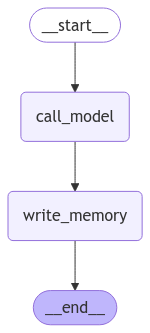

In [12]:
from IPython.display import Image, display

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.store.base import BaseStore

from langchain_core.messages import HumanMessage, SystemMessage, AIMessage
from langchain_core.runnables.config import RunnableConfig

# Chatbot instruction
MODEL_SYSTEM_MESSAGE = """You are a helpful assistant with memory that provides information about the user. 
If you have memory for this user, use it to personalize your responses.
Here is the memory (it may be empty): {memory}"""

# Create new memory from the chat history and any existing memory
CREATE_MEMORY_INSTRUCTION = """Create or update a user profile memory based on the user's chat history. 
This will be saved for long-term memory. If there is an existing memory, simply update it. 
Here is the existing memory (it may be empty): {memory}"""

def call_model(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Load memory from the store and use it to personalize the chatbot's response."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Retrieve memory from the store
    namespace = ("memory", user_id)
    existing_memory = store.get(namespace, "user_memory")

    # Format the memories for the system prompt
    if existing_memory and existing_memory.value:
        memory_dict = existing_memory.value
        formatted_memory = (
            f"Name: {memory_dict.get('user_name', 'Unknown')}\n"
            f"Interests: {', '.join(memory_dict.get('interests', []))}"
        )
    else:
        formatted_memory = None

    # Format the memory in the system prompt
    system_msg = MODEL_SYSTEM_MESSAGE.format(memory=formatted_memory)

    # Respond using memory as well as the chat history
    response = llm.invoke([SystemMessage(content=system_msg)]+state["messages"])

    return {"messages": response}

def write_memory(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Reflect on the chat history and save a memory to the store."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Retrieve existing memory from the store
    namespace = ("memory", user_id)
    existing_memory = store.get(namespace, "user_memory")

    # Format the memories for the system prompt
    if existing_memory and existing_memory.value:
        memory_dict = existing_memory.value
        formatted_memory = (
            f"Name: {memory_dict.get('user_name', 'Unknown')}\n"
            f"Interests: {', '.join(memory_dict.get('interests', []))}"
        )
    else:
        formatted_memory = None
        
    # Format the existing memory in the instruction
    system_msg = CREATE_MEMORY_INSTRUCTION.format(memory=formatted_memory)

    # Invoke the model to produce structured output that matches the schema
    new_memory = model_with_structure.invoke([SystemMessage(content=system_msg)]+state['messages'])

    # Overwrite the existing use profile memory
    key = "user_memory"
    store.put(namespace, key, new_memory)

# Define the graph
builder = StateGraph(MessagesState)
builder.add_node("call_model", call_model)
builder.add_node("write_memory", write_memory)
builder.add_edge(START, "call_model")
builder.add_edge("call_model", "write_memory")
builder.add_edge("write_memory", END)

# Store for long-term (across-thread) memory
across_thread_memory = InMemoryStore()

# Checkpointer for short-term (within-thread) memory
within_thread_memory = MemorySaver()

# Compile the graph with the checkpointer fir and store
graph = builder.compile(checkpointer=within_thread_memory, store=across_thread_memory)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [13]:
# We supply a thread ID for short-term (within-thread) memory
# We supply a user ID for long-term (across-thread) memory 
config = {"configurable": {"thread_id": "1", "user_id": "1"}}

# User input 
input_messages = [HumanMessage(content="Hi, my name is Zeeshan and I like to bike around San Francisco and eat at bakeries.")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Hi, my name is Zeeshan and I like to bike around San Francisco and eat at bakeries.
================================== Ai Message ==================================

Hello Zeeshan! It's nice to meet you.  

I'll remember that you like to bike around San Francisco and eat at bakeries.  

Is there anything specific you'd like to know or talk about today? Perhaps I could suggest some scenic bike routes or recommend a great bakery you haven't tried yet?  🚲🍰


In [14]:
# Namespace for the memory to save
user_id = "1"
namespace = ("memory", user_id)
existing_memory = across_thread_memory.get(namespace, "user_memory")
existing_memory.value

{'user_name': 'Zeeshan', 'interests': ['biking', 'eating at bakeries']}

## When can this fail?


In [15]:
from typing import List, Optional

class OutputFormat(BaseModel):
    preference: str
    sentence_preference_revealed: str

class TelegramPreferences(BaseModel):
    preferred_encoding: Optional[List[OutputFormat]] = None
    favorite_telegram_operators: Optional[List[OutputFormat]] = None
    preferred_telegram_paper: Optional[List[OutputFormat]] = None

class MorseCode(BaseModel):
    preferred_key_type: Optional[List[OutputFormat]] = None
    favorite_morse_abbreviations: Optional[List[OutputFormat]] = None

class Semaphore(BaseModel):
    preferred_flag_color: Optional[List[OutputFormat]] = None
    semaphore_skill_level: Optional[List[OutputFormat]] = None

class TrustFallPreferences(BaseModel):
    preferred_fall_height: Optional[List[OutputFormat]] = None
    trust_level: Optional[List[OutputFormat]] = None
    preferred_catching_technique: Optional[List[OutputFormat]] = None

class CommunicationPreferences(BaseModel):
    telegram: TelegramPreferences
    morse_code: MorseCode
    semaphore: Semaphore

class UserPreferences(BaseModel):
    communication_preferences: CommunicationPreferences
    trust_fall_preferences: TrustFallPreferences

class TelegramAndTrustFallPreferences(BaseModel):
    pertinent_user_preferences: UserPreferences

In [18]:

from pydantic import ValidationError

# Bind schema to model
model_with_structure = llm.with_structured_output(TelegramAndTrustFallPreferences)

# Conversation
conversation = """Operator: How may I assist with your telegram, sir?
Customer: I need to send a message about our trust fall exercise.
Operator: Certainly. Morse code or standard encoding?
Customer: Morse, please. I love using a straight key.
Operator: Excellent. What's your message?
Customer: Tell him I'm ready for a higher fall, and I prefer the diamond formation for catching.
Operator: Done. Shall I use our "Daredevil" paper for this daring message?
Customer: Perfect! Send it by your fastest carrier pigeon.
Operator: It'll be there within the hour, sir."""

# Invoke the model
try:
    model_with_structure.invoke(f"""Extract the preferences from the following conversation:
    <convo>
    {conversation}
    </convo>""")
except ValidationError as e:
    print(e)

BadRequestError: Error code: 400 - {'error': {'message': "Failed to call a function. Please adjust your prompt. See 'failed_generation' for more details.", 'type': 'invalid_request_error', 'code': 'tool_use_failed', 'failed_generation': '<tool-use>\n{\n\t"tool_call": {\n\t\t"id": "pending",\n\t\t"type": "function",\n\t\t"function": {\n\t\t\t"name": "TelegramAndTrustFallPreferences"\n\t\t},\n\t\t"parameters": {\n\t\t\t"pertinent_user_preferences": {\n\t\t\t\t"communication_preferences": {\n\t\t\t\t\t"morse_code": {\n\t\t\t\t\t\t"favorite_morse_abbreviations": [\n\t\t\t\t\t\t\t{\n\t\t\t\t\t\t\t\t"preference": "straight key",\n\t\t\t\t\t\t\t\t"sentence_preference_revealed": null\n\t\t\t\t\t\t\t}\n\t\t\t\t\t\t],\n\t\t\t\t\t\t"preferred_key_type": [\n\t\t\t\t\t\t\t{\n\t\t\t\t\t\t\t\t"preference": "straight key",\n\t\t\t\t\t\t\t\t"sentence_preference_revealed": null\n\t\t\t\t\t\t\t}\n\t\t\t\t\t\t]\n\t\t\t\t\t},\n\t\t\t\t\t"semaphore": {\n\t\t\t\t\t\t"preferred_flag_color": null,\n\t\t\t\t\t\t"semaphore_skill_level": null\n\t\t\t\t\t},\n\t\t\t\t\t"telegram": {\n\t\t\t\t\t\t"favorite_telegram_operators": null,\n\t\t\t\t\t\t"preferred_encoding": null,\n\t\t\t\t\t\t"preferred_telegram_paper": "Daredevil"\n\t\t\t\t\t}\n\t\t\t\t},\n\t\t\t\t"trust_fall_preferences": {\n\t\t\t\t\t"preferred_catching_technique": [\n\t\t\t\t\t\t{\n\t\t\t\t\t\t\t"preference": "diamond formation",\n\t\t\t\t\t\t\t"sentence_preference_revealed": null\n\t\t\t\t\t\t}\n\t\t\t\t\t],\n\t\t\t\t\t"preferred_fall_height": [\n\t\t\t\t\t\t{\n\t\t\t\t\t\t\t"preference": "higher",\n\t\t\t\t\t\t\t"sentence_preference_revealed": null\n\t\t\t\t\t\t}\n\t\t\t\t\t],\n\t\t\t\t\t"trust_level": null\n\t\t\t\t}\n\t\t\t}\n\t\t}\n\t}\n}\n</tool-use>'}}